In [3]:
#import csv

#print '2020-03-22_clean-dataset1'.csv.encode('latin1').decode('cp1251')

#reader = csv.reader(open(r'2020-03-22_clean-dataset1.csv', encoding='utf-8'),delimiter=' ')
#filtered = filter(lambda p: 'en' == p[10], reader)
#csv.writer(open(r"2020-03-22_clean-dataset-en.csv",'w'),delimiter=' ').writerows(filtered)

import pandas as pd

data = pd.read_csv('2020-03-22_clean-dataset1.csv')
# Filter to only English entries.
data = data[data['lang'] == 'en']
#remove columns other than the tweet 
data.drop(data.columns.difference(['text']), 1, inplace=True)
data.head()

,text
0,President Rodrigo Duterte: COVID-19 MASS TESTI...
1,This terrifies me as a children’s lawyer. With...
6,And no matter what they do fails they will bla...
7,OMG My neighbour just told me her cousin worke...
8,"Surgeon General Looks to Kylie Jenner, Other I..."


In [29]:
import os

os.chdir('..')

In [9]:
# Load the regular expression library
import re

# Remove punctuation
data['tweet_text_processed'] = data['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
data['tweet_text_processed'] = data['tweet_text_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
data['tweet_text_processed'].head()
print(data)

                                                     text  \
0       President Rodrigo Duterte: COVID-19 MASS TESTI...   
1       This terrifies me as a children’s lawyer. With...   
6       And no matter what they do fails they will bla...   
7       OMG My neighbour just told me her cousin worke...   
8       Surgeon General Looks to Kylie Jenner, Other I...   
...                                                   ...   
654978  @albericie @mattmua72 @ScottMorrisonMP You don...   
654979  This is a death sentence to 2 million American...   
654983       @annabelcrabb Maybe? https://t.co/V92icYKBAo   
654984  Yukon sees its first two COVID-19 cases — a co...   
654988            Fuck sake. 🙆‍♂️ https://t.co/3HMritdC0h   

                                     tweet_text_processed  
0       president rodrigo duterte: covid-19 mass testi...  
1       this terrifies me as a children’s lawyer with ...  
6       and no matter what they do fails they will bla...  
7       omg my neighbour ju

In [11]:
data.to_csv('checking_stuff.csv')

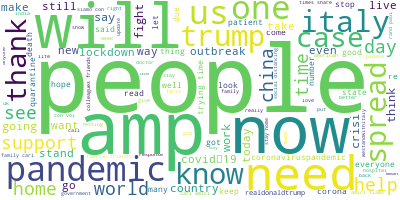

In [20]:
# Import the wordcloud library
from wordcloud import WordCloud, STOPWORDS

# Join the different processed titles together.
long_string = ','.join(list(data['tweet_text_processed'].values))

#add stopwords from twitter and take out covid stuff we know the tweets are about covid
stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "coronavirus","19","coronaviruspandemic", "don", "amp"] + list(STOPWORDS)

# Create a WordCloud object
wordcloud = WordCloud(stopwords = stop_words, background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

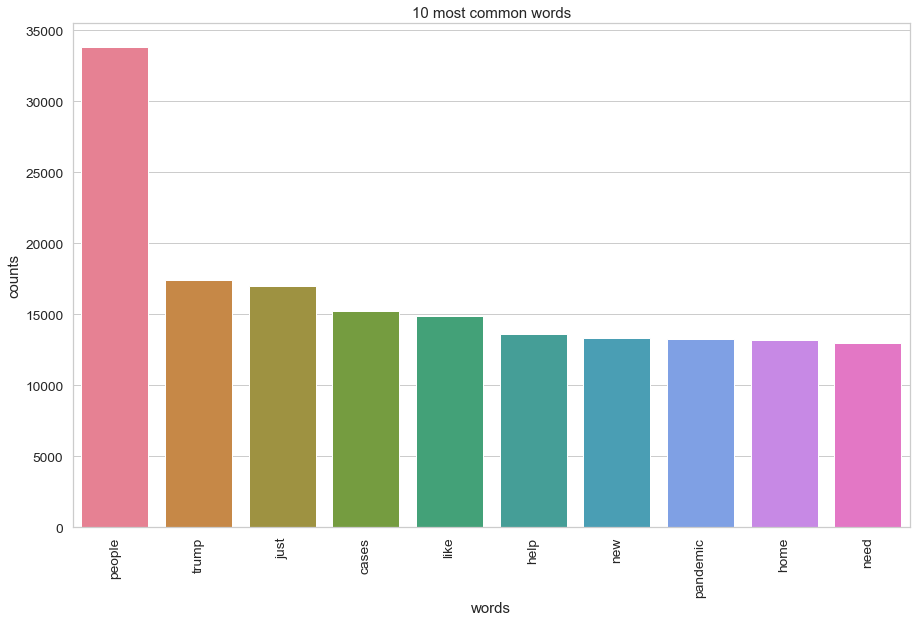

In [24]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words and same ones from wordcloud
my_additional_stop_words = ["https", "co", "rt", "tco", "covid", "coronaviru", "covid19", "virus", "coronavirus","19","coronaviruspandemic", "don", "amp", "covidー19"]
count_vectorizer = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words))

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(data['tweet_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [25]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
spread health people social help world fight good india distancing

Topic #1:
cases new deaths italy death people confirmed total number state

Topic #2:
trump people just like realdonaldtrump know time china need pandemic

Topic #3:
stay home people safe covidー19 day just tested need got

Topic #4:
friends family positive times share support italy italian trying stand


In [34]:
%%time

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

Wall time: 5min 27s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.105349  0.149389       1        1  31.923747
0     -0.089564 -0.028663       2        1  22.802391
1     -0.034741 -0.136412       3        1  18.988585
3     -0.044219 -0.013001       4        1  17.255165
4      0.273873  0.028688       5        1   9.030112, topic_info=              Term          Freq         Total Category  logprob  loglift
104926       cases  13354.000000  13354.000000  Default  30.0000  30.0000
178423     friends   7915.000000   7915.000000  Default  29.0000  29.0000
435037       trump  15886.000000  15886.000000  Default  28.0000  28.0000
410283        stay  11090.000000  11090.000000  Default  27.0000  27.0000
210442        home  11657.000000  11657.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
395553        self   1077.064480   3948.384636   Topic5  -5.8249   1.1055
193233  government   1203.141980   6975.949383   Topic5  -5.7142   0.6471
423196     testing   1113.141915   4995.520682   Topic5  -5.7920   0.9033
352109   president   1121.484288   5781.929487   Topic5  -5.7845   0.7645
338692    pandemic   1169.142376  11785.878989   Topic5  -5.7429   0.0940

[417 rows x 6 columns], token_table=        Topic      Freq   Term
term                          
447         1  0.002263     03
447         2  0.004525     03
447         3  0.925403     03
447         4  0.065615     03
5220        1  0.013501     10
...       ...       ...    ...
498835      1  0.001686   york
498835      2  0.001686   york
498835      3  0.995374   york
498835      5  0.001265   york
501340      4  0.994826  yuval

[965 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4, 5])